# PANDAPROSUMER EXAMPLE: HEAT PUMP WITH HEAT STRATIFIED STORAGE

## DESCRIPTION:
This example describes how to create a single heat pump element in pandaprosumer and connect it to a heat stratified storage unit which is then connected to a single consumer (heat demand). The demand and source temperature data is read from an Excel file and stored in pandas dataframe. It includes the information about the power required by the consumer and source temperature at each time step.

This tutorial illustrates how to use the **Stratified Heat Storage** controller


![title](img/hp_shs_hd.png)

## Glossary:
- Network: A configuration of connected energy generators and energy consumers
- Element: A single energy generator or a single energy consumer
- Controller: The logic of an element that defines its behaviour and its limits
- Prosumer/Container: A pandaprosumer data structure that holds data related to elements and their controllers.
- Const Profile Controller: The initial controller in the network that interacts with other element controllers; it also manages external data via time series.
- Map / mapping: A connection between two controllers that specifies what information is exchanged between the corresponding elements.

## Network design philosophy:
In pandaprosumer, a system's component is represented by a network element. Each element is assigned a container and its own element controller. A container is a structure that contains the component's configuration data (static input data), which can include information that will not change in the analysis such as size, nominal power, efficiency, etc. The behaviour of an element is governed by its controller. Connections between elements are defined in maps, which couple output parameters of one controller to the input parameter of a controller of a connected element. The network is managed by a controller called ConstProfileController. This controller is connected to all element controllers and manages dynamic input data from external sources (e.g. Excel file). For each time step it distributes the dynamic input data to the relevant element controllers.

# 1 - INPUT DATA:
First let's import libraries required for data management.

In [1]:
import pandas as pd
from pandapower.timeseries.data_sources.frame_data import DFData

Next we need to define properties of the heat pump which are treated as static input data, i.e. data (characteristics) that don't change during an analysis. In this case the properties for the heat pump are :

- `carnot_efficiency`: The efficiency of the heat pump relative to the Carnot cycle (dimensionless, between 0 and 1).
- `pinch_c`: The pinch point temperature difference (°C), which represents the minimum temperature difference in the heat exchanger.
- `delta_t_evap_c`: The temperature difference at the evaporator (°C).
- `max_p_comp_kw`: The maximum compressor power (kW), which limits the heat pump's capacity.
- `name`: A label identifying the heat pump.


Next, we define the properties of the **stratified heat storage (SHS)**, which is used to store thermal energy. The SHS parameters include physical dimensions, insulation properties, and temperature constraints.

- `tank_height_m`: The height of the storage tank (meters).
- `tank_internal_radius_m`: The internal radius of the tank (meters).
- `tank_external_radius_m`: The external radius of the tank (meters).
- `insulation_thickness_m`: The thickness of the tank's insulation (meters).
- `n_layers`: The number of discrete layers used for thermal stratification.
- `min_useful_temp_c`: The minimum temperature (°C) at which stored heat is considered useful.
- `t_ext_c`: The external ambient temperature (°C).
- `name`: A label for the heat storage system.

 While these arguments are generally optional, in our specific case they are required in order to fully configure the heat exchanger. Other optional arguments are also available for more advanced configurations.



In [2]:
hp_params = {"carnot_efficiency": 0.5,
             "pinch_c": 0,
             "delta_t_evap_c": 5,
             "max_p_comp_kw": 200,
             "name":'air_water_heat_pump'}

shs_params = {"tank_height_m": 10.,
              "tank_internal_radius_m": 0.564,
              "tank_external_radius_m": 0.664,
              "insulation_thickness_m": .1,
              "n_layers": 100,
              "min_useful_temp_c": 80,
              "t_ext_c": 20,
              "max_dt_s": 1,
              "t_discharge_out_tol_c": 1,
              "name":'tank_heat_storage'}

hd_params = {"name": 'heat_consumer'}


We define the analysis time series.

In [3]:
start = '2020-01-01 00:00:00'
end = '2020-01-01 23:59:59'
time_resolution_s = 900

Now we import our demand data and transform it into an appropriate DFData object. All data of an individual element is stored in a dedicated DFData object.

In [4]:
import sys
import os

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

demand_data = pd.read_excel('data/hp_data.xlsx')

dur = pd.date_range(start=start, end=end, freq='900s',tz='utc')
demand_data.index = dur
demand_input = DFData(demand_data)
demand_input.df.head(10)


,t_air,demand_power,t_feed_demand_c,t_return_demand_c
2020-01-01 00:00:00+00:00,25,0,80,20
2020-01-01 00:15:00+00:00,25,0,80,20
2020-01-01 00:30:00+00:00,25,0,80,20
2020-01-01 00:45:00+00:00,25,0,80,20
2020-01-01 01:00:00+00:00,25,0,80,20
2020-01-01 01:15:00+00:00,25,500,80,20
2020-01-01 01:30:00+00:00,25,500,80,20
2020-01-01 01:45:00+00:00,25,500,80,20
2020-01-01 02:00:00+00:00,25,321,80,20
2020-01-01 02:15:00+00:00,25,321,80,20


We can plot the evolution of the demand from the Excel file.

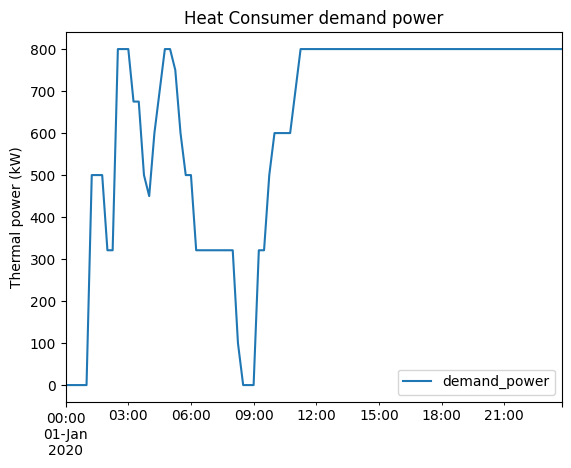

In [5]:
import matplotlib.pyplot as plt

demand_input.df.plot(y='demand_power')
plt.title("Heat Consumer demand power")
plt.ylabel("Thermal power (kW)")
plt.show()

# 2 - CREATING ELEMENTS OF THE NETWORK:
In this example, the network is made up of three elements: a source, storage and a consumer. The source is represented by a single heat pump, storage is defined by heat stratified storage element and the consumer is modelled by a single heat demand element.

We begin by defining an empty prosumer container object and then add the different elements and their respective controllers to it.

In [6]:
from pandaprosumer.create import create_empty_prosumer_container

prosumer = create_empty_prosumer_container()

Then we define the period of the analysis using input data about the analysis of time and also timezone and period name.

In [7]:
from pandaprosumer.create import create_period

period_id = create_period(prosumer, time_resolution_s, start, end, 'utc', 'default')

Now we can create the controllers connected to their respective containers and data. We also define the topology of the network by setting the elements' priority. In this example, the network has a linear configuration (the direction of energy flow goes in one direction), so only the order parameter is set:

- The const profile controller is always the first element in the network and is the only one that reads data from external sources (order 0, level 0),
- As the source, the heat pump controller is the second element (order 0, level 1) in the network,
- Third element represents heat storage(order 1, level 1),
 -The final order is the demand (order 2, level 1).

We begin by creating the Const Profile Controller.

In [8]:
from pandaprosumer.create_controlled import create_controlled_const_profile

cp_input_columns = ["t_air", "demand_power", "t_feed_demand_c", "t_return_demand_c"]
cp_result_columns = ["t_evap_in_c", "qdemand_kw", "t_feed_demand_c", "t_return_demand_c"]
cp_controller_index = create_controlled_const_profile(prosumer, cp_input_columns, cp_result_columns, demand_input, period_id, 0, 0)

The heat pump, Stratified Heat Storage and Heat demand controllers are now created

In [9]:
from pandaprosumer.create_controlled import create_controlled_heat_pump,create_controlled_stratified_heat_storage,create_controlled_heat_demand

hp_controller_index = create_controlled_heat_pump(prosumer, period=period_id, level=1, order=0, **hp_params)
shs_controller_index = create_controlled_stratified_heat_storage(prosumer, period=period_id, level=1, order=1, **shs_params)
hd_controller_index = create_controlled_heat_demand(prosumer, period=period_id, level=1, order = 2,**hd_params)

We can check that the elements were connected added to the prosumer with the specified parameters

In [10]:
prosumer.heat_pump

,name,delta_t_evap_c,carnot_efficiency,pinch_c,delta_t_hot_default_c,max_p_comp_kw,min_p_comp_kw,max_t_cond_out_c,max_cop,cond_fluid,evap_fluid,in_service
0,air_water_heat_pump,5.0,0.5,0.0,5.0,200.0,NaN,NaN,NaN,water,water,True


In [11]:
prosumer.stratified_heat_storage

,name,tank_height_m,tank_internal_radius_m,tank_external_radius_m,insulation_thickness_m,n_layers,min_useful_temp_c,k_fluid_w_per_mk,k_insu_w_per_mk,k_wall_w_per_mk,h_ext_w_per_m2k,t_ext_c,max_remaining_capacity_kwh,t_discharge_out_tol_c,max_dt_s,height_charge_in_m,height_charge_out_m,height_discharge_out_m,height_discharge_in_m,in_service
0,tank_heat_storage,10.0,0.564,0.664,0.1,100,80.0,0.598,0.028,45.0,12.5,20.0,1.0,1.0,1.0,NaN,0.0,NaN,0.0,True


In [12]:
prosumer.heat_demand

,name,scaling,in_service
0,heat_consumer,1.0,True


Additionnaly, we can check that for each element, a controller has been added to the prosumer

In [13]:
prosumer.controller

,object,in_service,order,level,initial_run,recycle
0,ConstProfileController,True,0,0,True,False
1,HeatPumpController,True,0,1,True,False
2,StratifiedHeatStorageController,True,1,1,True,False
3,HeatDemandController,True,2,1,True,False


We can also get the element associated to one controller:

In [14]:
prosumer.controller.loc[1, 'object'].element_instance

,name,delta_t_evap_c,carnot_efficiency,pinch_c,delta_t_hot_default_c,max_p_comp_kw,min_p_comp_kw,max_t_cond_out_c,max_cop,cond_fluid,evap_fluid,in_service
0,air_water_heat_pump,5.0,0.5,0.0,5.0,200.0,NaN,NaN,NaN,water,water,True


# 4 - CREATING CONNECTIONS (MAPS) BETWEEN THE CONTROLLERS:
network configuration

For each controller we define how it is connected to other controllers.


In [15]:
from pandaprosumer.mapping import GenericMapping
from pandaprosumer.mapping import FluidMixMapping

CONNECTION CONST PROFILE CONTROLLER ---> HEAT PUMP:

The connection from the Const Profile Controller to the Heat Pump Controller enables the heat pump to access the t_air column from the input time series dataset.

In [16]:
GenericMapping(prosumer,
               initiator_id=cp_controller_index,
               initiator_column="t_evap_in_c",
               responder_id=hp_controller_index,
               responder_column="t_evap_in_c",
               order=0)

CONNECTION CONST PROFILE CONTROLLER ---> HEAT DEMAND:

The connection from the Const Profile Controller to the Heat Demand Controller enables the heat demand to access the demand_power, t_feed_demand_c, t_return_demand_c columns from the input time series dataset.

The order=1 in this mapping between ConstProfileController and HeatDemandController defines the sequence in which this mapping is applied, relative to other mappings from the ConstProfileController. It ensures that this mapping happens in the correct order if there are multiple mappings from the same initiator controller.

This mapping order is separate from the controller execution order, which defines when the controllers themselves are executed during each simulation step. The order=1 ensures the data flows in the intended sequence without affecting the overall controller run order.

In [17]:
GenericMapping(prosumer,
               initiator_id=cp_controller_index,
               initiator_column=["qdemand_kw", "t_feed_demand_c", "t_return_demand_c"],
               responder_id=hd_controller_index,
               responder_column=["q_demand_kw", "t_feed_demand_c", "t_return_demand_c"],
               order=1)

CONNECTION HEAT PUMP ---> HEAT STRATIFIED STORAGE:

The connection between the Heat Pump Controller and the Heat Stratified Storage Controller allows the storage to read the heat pump’s output and use it as an input for its own calculations. Instead of a generic mapping, a fluid mix mapping is used—this is necessary because the parameters being exchanged, such as mass flow, are dynamic and not static.

In [18]:
FluidMixMapping(prosumer,
                initiator_id=hp_controller_index,
                responder_id=shs_controller_index,
                order=0)

HEAT STATIFIED STORAGE ---> HEAT DEMAND:

In [19]:
FluidMixMapping(prosumer,
                initiator_id=shs_controller_index,
                responder_id=hd_controller_index,
                order=0)

5 - RUNNING THE ANALYSIS:
We can now run the analysis with the input data defined above.

In [20]:
from pandaprosumer.run_time_series import run_timeseries

run_timeseries(prosumer, period_id, verbose=True)

100%|██████████| 96/96 [00:15<00:00,  6.23it/s]


# 6 - PRINTING AND PLOTTING RESULTS:
All the results of the timeseries analysis are available in the prosumer.time_series dataframe

In [21]:
prosumer.time_series

,name,element,element_index,period_index,data_source
0,air_water_heat_pump,heat_pump,0.0,0.0,DFData
1,tank_heat_storage,stratified_heat_storage,0.0,0.0,DFData
2,heat_consumer,heat_demand,0.0,0.0,DFData


Before plotting we have to look at the resulting dataframe to see which quantity (column) do we want to plot.

Access the results of the heat pump:

In [22]:
prosumer.time_series.data_source.loc[0].df.head(10)

,q_cond_kw,p_comp_kw,q_evap_kw,cop,mdot_cond_kg_per_s,t_cond_in_c,t_cond_out_c,mdot_evap_kg_per_s,t_evap_in_c,t_evap_out_c
2020-01-01 00:00:00+00:00,642.090909,200.000000,442.090909,3.210455,2.559220,20.000000,80.0,21.137929,25.0,20.0
2020-01-01 00:15:00+00:00,642.090909,200.000000,442.090909,3.210455,2.559220,20.000000,80.0,21.137929,25.0,20.0
2020-01-01 00:30:00+00:00,642.090909,200.000000,442.090909,3.210455,2.559220,20.000000,80.0,21.137929,25.0,20.0
2020-01-01 00:45:00+00:00,642.090909,200.000000,442.090909,3.210455,2.559220,20.000000,80.0,21.137929,25.0,20.0
2020-01-01 01:00:00+00:00,642.090909,200.000000,442.090909,3.210455,2.559220,20.000003,80.0,21.137929,25.0,20.0
2020-01-01 01:15:00+00:00,510.749234,159.089384,351.659851,3.210455,12.782953,70.472743,80.0,16.814101,25.0,20.0
2020-01-01 01:30:00+00:00,500.000000,155.741186,344.258814,3.210455,1.992880,20.000000,80.0,16.460231,25.0,20.0
2020-01-01 01:45:00+00:00,500.000000,155.741186,344.258814,3.210455,1.992880,20.000000,80.0,16.460231,25.0,20.0
2020-01-01 02:00:00+00:00,328.665468,102.373500,226.291968,3.210455,12.069640,73.508488,80.0,10.819819,25.0,20.0
2020-01-01 02:15:00+00:00,321.000000,99.985842,221.014158,3.210455,1.279429,20.000000,80.0,10.567468,25.0,20.0


Access the results of the stratified heat storage:

In [23]:
prosumer.time_series.data_source.loc[1].df.head(10)

,mdot_discharge_kg_per_s,t_discharge_c,q_delivered_kw,e_stored_kwh
2020-01-01 00:00:00+00:00,0.0,20.000000,0.0,115.438064
2020-01-01 00:15:00+00:00,0.0,79.999432,0.0,264.739778
2020-01-01 00:30:00+00:00,0.0,79.999431,0.0,332.564562
2020-01-01 00:45:00+00:00,0.0,79.999432,0.0,332.564809
2020-01-01 01:00:00+00:00,0.0,79.999432,0.0,332.565272
2020-01-01 01:15:00+00:00,0.0,79.999433,0.0,678.981424
2020-01-01 01:30:00+00:00,0.0,79.999870,0.0,678.444711
2020-01-01 01:45:00+00:00,0.0,79.979609,0.0,33.915112
2020-01-01 02:00:00+00:00,0.0,79.950603,0.0,678.976615
2020-01-01 02:15:00+00:00,0.0,79.999870,0.0,658.099513


Access the results of the heat demand:

In [24]:
prosumer.time_series.data_source.loc[2].df.head(10)

,q_received_kw,q_uncovered_kw,mdot_kg_per_s,t_in_c,t_out_c
2020-01-01 00:00:00+00:00,0.0,0.000000e+00,0.000000,20.000000,20.0
2020-01-01 00:15:00+00:00,0.0,0.000000e+00,0.000000,79.999432,20.0
2020-01-01 00:30:00+00:00,0.0,0.000000e+00,0.000000,79.999431,20.0
2020-01-01 00:45:00+00:00,0.0,0.000000e+00,0.000000,79.999432,20.0
2020-01-01 01:00:00+00:00,0.0,0.000000e+00,0.000000,79.999432,20.0
2020-01-01 01:15:00+00:00,500.0,5.684342e-14,1.992880,80.000000,20.0
2020-01-01 01:30:00+00:00,500.0,5.684342e-14,1.992880,80.000000,20.0
2020-01-01 01:45:00+00:00,500.0,5.684342e-14,1.992880,80.000000,20.0
2020-01-01 02:00:00+00:00,321.0,0.000000e+00,1.279429,80.000000,20.0
2020-01-01 02:15:00+00:00,321.0,0.000000e+00,1.279429,80.000000,20.0


Alternatively, if the elements have unique names, we can change the indexing of the result dataframe to use the name of the elements as index and access the results more directly.

In [25]:
res_df = prosumer.time_series.copy()
res_df.set_index('name', inplace=True)

In [26]:
res_df

,element,element_index,period_index,data_source
name,,,,
air_water_heat_pump,heat_pump,0.0,0.0,DFData
tank_heat_storage,stratified_heat_storage,0.0,0.0,DFData
heat_consumer,heat_demand,0.0,0.0,DFData


Thanks to the presence of the storage, the heat pump will provide its maximum power most of the time, thus running at constant load.

The power of the heat pump is reduced only when the storage is full

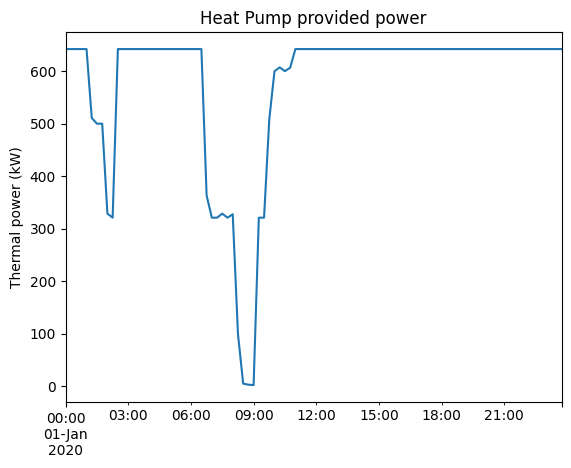

In [27]:
res_df.data_source.loc['air_water_heat_pump'].df.q_cond_kw.plot()
plt.title("Heat Pump provided power")
plt.ylabel("Thermal power (kW)")
plt.show()

The storage is delivering heat (discharging) to the heat consumer only when the heat pump alone cannot meet the demand.

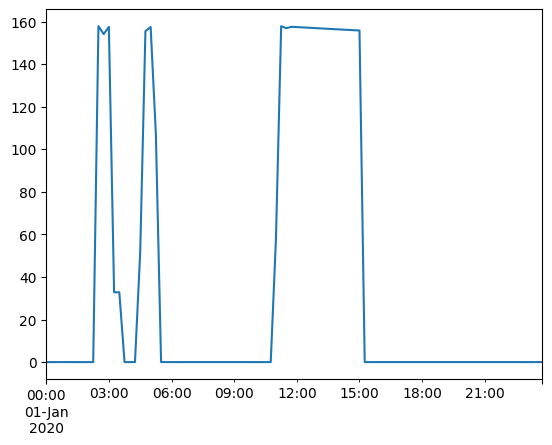

In [28]:
res_df.data_source.loc['tank_heat_storage'].df.q_delivered_kw.plot()
plt.show()

The next graph shows the stored energy in the stratified heat storage (SHS). When demand spikes, the heat pump diverts all available output to meet that demand, leaving no surplus for storage, consequently, by the end, there's no energy left to store as the demand is high for a long period of time. The sharp drops in stored energy align with discharge events (q_discharge), which occur whenever the system must cover a sudden increase in heat demand.

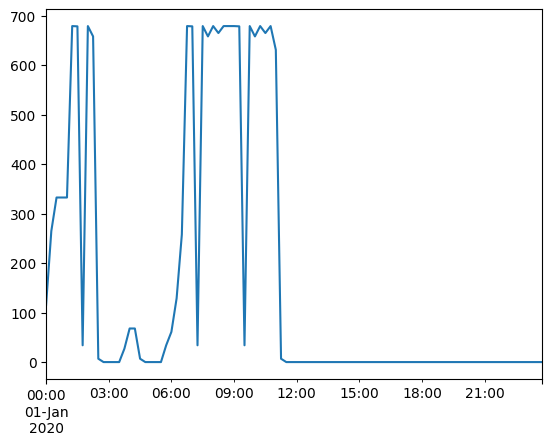

In [29]:
res_df.data_source.loc['tank_heat_storage'].df.e_stored_kwh.plot()
plt.show()

Thanks to the storage, the demand is met even during the peaks, when the heat pump alone would not have been powerful enough.

However at the end of the example timeseries, the demand is high for a long time. When the storage gets discharged, the demand cannot be met fully anymore.

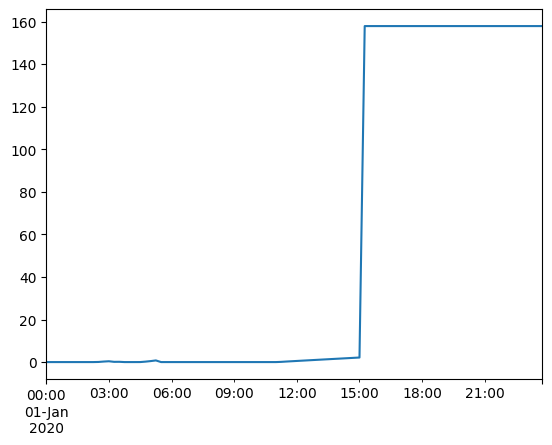

In [30]:
res_df.data_source.loc['heat_consumer'].df.q_uncovered_kw.plot()
plt.show()